In [60]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_mps_initializer.datatypes import QuantumState
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity 

def setup_registers_and_states(psi_vec, phi_vec, n, number_of_layers):
    """Creates quantum registers and MPS initializers for ψ and φ."""
    psi_state = QuantumState.from_dense_data(data=psi_vec, normalize=True)
    phi_state = QuantumState.from_dense_data(data=phi_vec, normalize=True)
    
    U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
    U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
    U_phi_dagger = U_phi.inverse()
    
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    
    return psi_reg, phi_reg, U_psi, U_phi, U_phi_dagger


In [61]:
def build_protocol(psi_reg, phi_reg, U_psi, U_phi, U_phi_dagger, delta, m):
    qc = QuantumCircuit(psi_reg, phi_reg)
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(1, m + 1):
        for i in range(n):
            qc.cx(phi_reg[n - 1 - i], psi_reg[n - 1 - i], ctrl_state=0)
        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        qc.append(U_phi_dagger, phi_reg)
        qc.reset(phi_reg)
        if k < m:
            qc.append(U_phi, phi_reg)

    return qc


In [62]:
def get_phase_amplitude(qc, n):
    """
    Takes a prebuilt circuit qc (already includes uncompute)
    and returns amplitude and phase of ψ subsystem.
    """
    sim = AerSimulator(method="statevector")
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # Trace out φ (ancilla)
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))
    vec = np.array(rho_psi.to_statevector())  # should now be pure
    vec /= np.linalg.norm(vec)

    # Align global phase
    idx0 = np.flatnonzero(np.abs(vec) > 1e-12)[0] if np.any(np.abs(vec) > 1e-12) else 0
    phase = np.angle(vec[idx0])
    vec_aligned = vec * np.exp(-1j * phase)

    amps = np.abs(vec_aligned)
    phases = np.unwrap(np.angle(vec_aligned))
    return amps, phases


In [63]:
import pandas as pd

def save_run_data(phi_vec, delta, m, amps, phases, file="training_data.csv"):
    df = pd.DataFrame({
        "phi": [phi_vec.tolist()],
        "delta": [delta],
        "m": [m],
        "amps": [amps.tolist()],
        "phases": [phases.tolist()]
    })
    df.to_csv(file, mode='a', header=False, index=False)
    print(f"✅ Data saved for δ={delta}, m={m}")


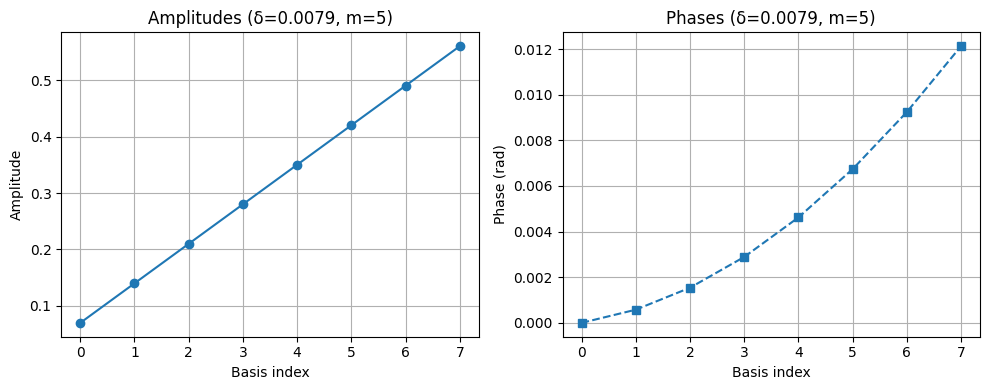

✅ Data saved for δ=0.007853981633974483, m=5


In [64]:
# --- parameters ---
psi = [1,2,3,4,5,6,7,8]
n = 3
number_of_layers = 2
delta = np.pi/400
m = 5

# --- choose a phi (you’ll vary this later) ---
phi = np.linspace(1,8,8)  # flat, linear, exponential, random, etc.

# Step 1: setup
psi_reg, phi_reg, U_psi, U_phi, U_phi_dagger = setup_registers_and_states(psi, phi, n, number_of_layers)

# Step 2: build circuit
qc = build_protocol(psi_reg, phi_reg, U_psi, U_phi, U_phi_dagger, delta, m)

# Step 3: simulate + get data
amps, phases = get_phase_amplitude(qc, n)

# Step 4: plot and save
plot_phase_amplitude(amps, phases, delta, m)
save_run_data(phi, delta, m, amps, phases, "dataset.csv")



▶ Running φ type: flat


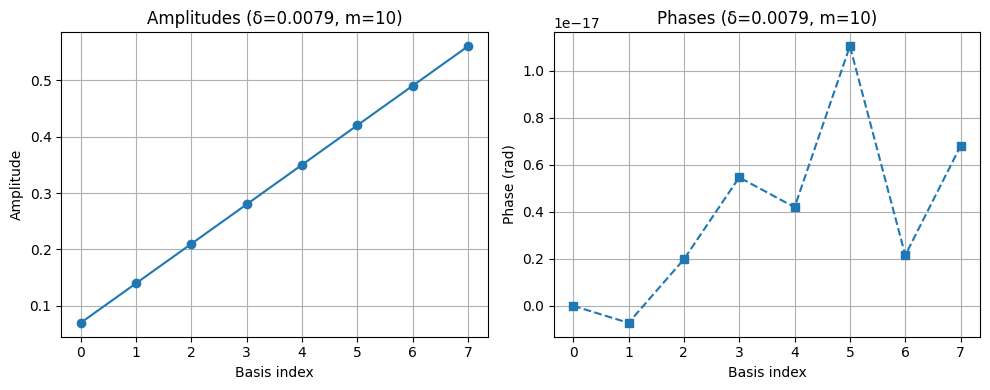

✅ Data saved for δ=0.007853981633974483, m=10

▶ Running φ type: linear


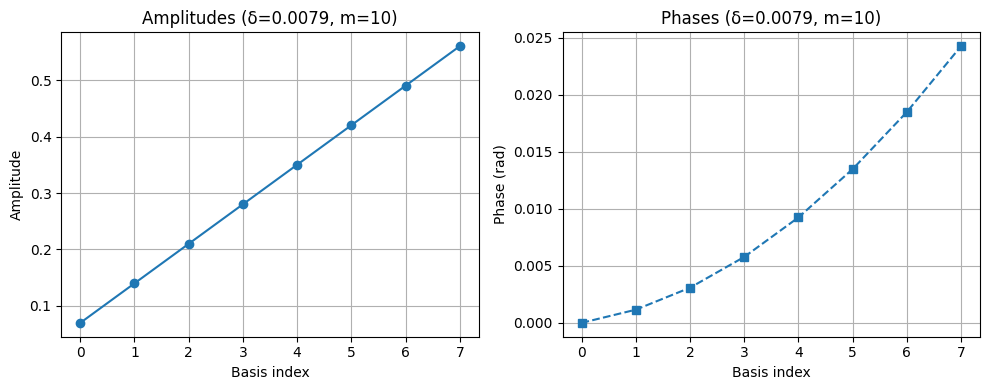

✅ Data saved for δ=0.007853981633974483, m=10

▶ Running φ type: exponential


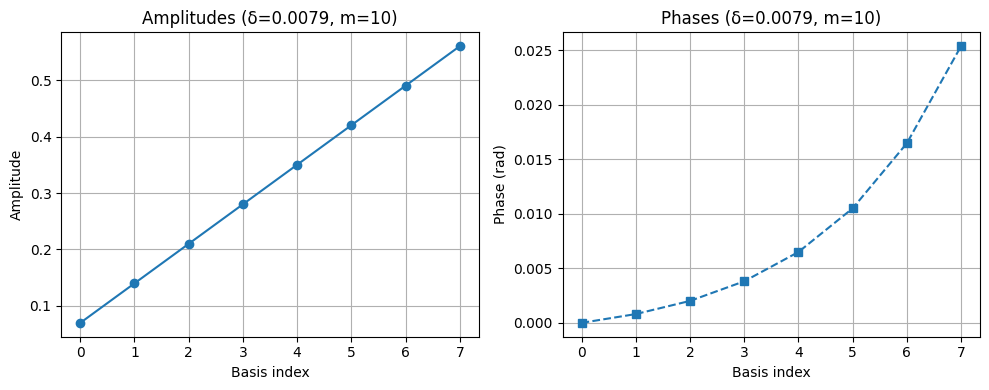

✅ Data saved for δ=0.007853981633974483, m=10

▶ Running φ type: periodic


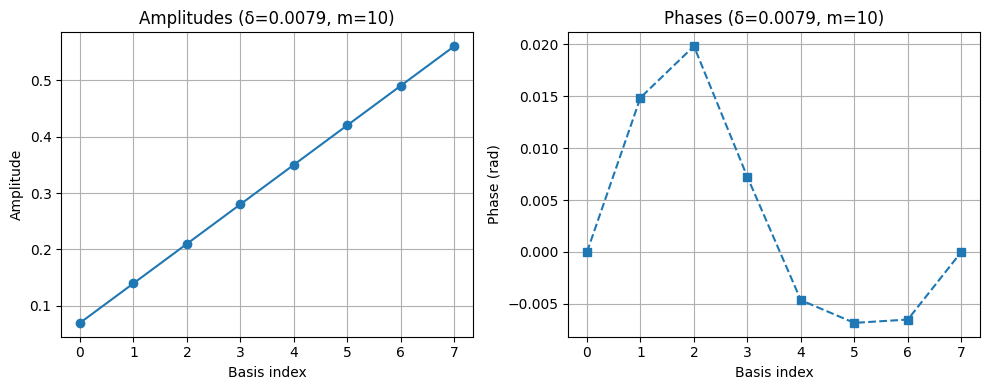

✅ Data saved for δ=0.007853981633974483, m=10

▶ Running φ type: random


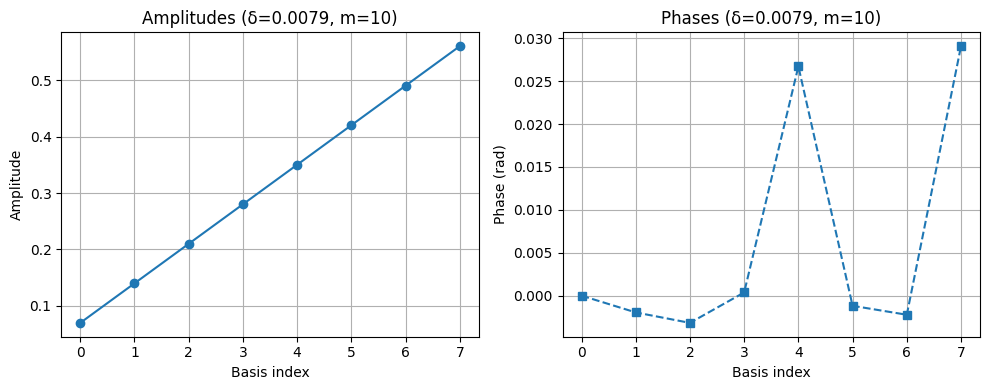

✅ Data saved for δ=0.007853981633974483, m=10


In [65]:
# === Step 6: run the full data generation for all φ types ===

phi_types = {
    "flat": np.ones(8),
    "linear": np.linspace(1, 8, 8),
    "exponential": np.exp(0.2 * np.arange(8)),
    "periodic": 1 + np.sin(np.linspace(0, 2 * np.pi, 8)),
    "random": np.random.rand(8)
}

delta = np.pi / 400  # you can change this later
m = 10               # number of iterations

for name, phi in phi_types.items():
    print(f"\n▶ Running φ type: {name}")
    psi_reg, phi_reg, U_psi, U_phi, U_phi_dagger = setup_registers_and_states(psi, phi, n, number_of_layers)
    qc = build_protocol(psi_reg, phi_reg, U_psi, U_phi, U_phi_dagger, delta, m)
    amps, phases = get_phase_amplitude(qc, n)
    plot_phase_amplitude(amps, phases, delta, m)
    save_run_data(phi, delta, m, amps, phases, f"dataset_{name}.csv")


In [66]:
import pandas as pd
import glob
import ast

def load_and_clean_datasets(pattern="dataset_*.csv", N=8):
    """
    Reads all dataset CSV files matching the pattern and returns
    a single cleaned DataFrame with numeric columns:
      phi_*, delta, m, amp_*, phase_*
    """
    all_dfs = []
    files = glob.glob(pattern)
    print(f"Found {len(files)} files: {files}")

    for f in files:
        print(f"Processing {f}...")
        # read as raw strings (no header)
        raw = pd.read_csv(f, header=None)

        # convert any list-like string into actual Python lists
        raw = raw.applymap(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
        )

        # figure out which columns contain what (adjust indexes if needed)
        # Example order: [phi, delta, m, amps, phases]
        phi_cols = pd.DataFrame(raw.iloc[:, 0].tolist(), columns=[f"phi_{i}" for i in range(N)])
        delta = raw.iloc[:, 1].astype(float).rename("delta")
        m = raw.iloc[:, 2].astype(int).rename("m")
        amp_cols = pd.DataFrame(raw.iloc[:, 3].tolist(), columns=[f"amp_{i}" for i in range(N)])
        phase_cols = pd.DataFrame(raw.iloc[:, 4].tolist(), columns=[f"phase_{i}" for i in range(N)])

        # combine into one tidy frame
        clean = pd.concat([phi_cols, delta, m, amp_cols, phase_cols], axis=1)
        all_dfs.append(clean)

    # merge all into one dataset
    df = pd.concat(all_dfs, ignore_index=True)
    print(f"Final combined dataset shape: {df.shape}")
    return df


# --- use it ---
df = load_and_clean_datasets("dataset_*.csv", N=8)

# sanity check
print(df.head())

# Example: extract feature and target sets for ML
X = df[[c for c in df.columns if c.startswith('phi_')] + ['delta','m']]
y = df[[c for c in df.columns if c.startswith('amp_') or c.startswith('phase_')]]
print(f"X shape: {X.shape}, y shape: {y.shape}")


Found 5 files: ['dataset_flat.csv', 'dataset_exponential.csv', 'dataset_linear.csv', 'dataset_random.csv', 'dataset_periodic.csv']
Processing dataset_flat.csv...
Processing dataset_exponential.csv...
Processing dataset_linear.csv...
Processing dataset_random.csv...
Processing dataset_periodic.csv...
Final combined dataset shape: (15, 26)
   phi_0     phi_1     phi_2     phi_3     phi_4     phi_5     phi_6   phi_7  \
0    1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.0000   
1    1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.0000   
2    1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.0000   
3    1.0  1.221403  1.491825  1.822119  2.225541  2.718282  3.320117  4.0552   
4    1.0  1.221403  1.491825  1.822119  2.225541  2.718282  3.320117  4.0552   

      delta   m  ...     amp_6     amp_7       phase_0       phase_1  \
0  0.007854   5  ...  0.490098  0.560112 -2.158798e-35  1.524081e-18   
1  0.007854  10  ...  0.490098  0.5

/tmp/ipykernel_951566/2469348034.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(
/tmp/ipykernel_951566/2469348034.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(
/tmp/ipykernel_951566/2469348034.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(
/tmp/ipykernel_951566/2469348034.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(
/tmp/ipykernel_951566/2469348034.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# --- separate input features and output targets ---
# inputs: all φ components + δ + m
X = df[[c for c in df.columns if c.startswith('phi_')] + ['delta', 'm']]

# targets: all amplitude and phase components
y = df[[c for c in df.columns if c.startswith('amp_') or c.startswith('phase_')]]

# --- split into training and test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# --- train a model (you can adjust n_estimators for more accuracy) ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- evaluate on test data ---
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.6f}")

# --- example: predict for one new phi pattern ---
import numpy as np
phi_new = np.linspace(1, 8, 8) / np.linalg.norm(np.linspace(1, 8, 8))
delta_new = np.pi / 200
m_new = 10

X_new = np.concatenate([phi_new, [delta_new, m_new]]).reshape(1, -1)
y_pred_new = model.predict(X_new)

amps_pred = y_pred_new[0][:8]
phases_pred = y_pred_new[0][8:]

print("\nPredicted amplitudes:", amps_pred)
print("Predicted phases:", phases_pred)


R² score: -3.6789
Mean Absolute Error: 0.006079

Predicted amplitudes: [0.07001431 0.14002897 0.21003688 0.28006017 0.35007169 0.42008378
 0.49010086 0.56010827]
Predicted phases: [-6.15336165e-21  1.56311475e-04  1.18395455e-02 -2.70802991e-03
 -3.76583822e-06  2.13052419e-03 -2.22324576e-04  3.91289775e-03]


/workspaces/QCproject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
